daha fazla veri ile(mantarImage + image iNaturalistten çekilenlerle)

In [1]:
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. EarlyStopping ve ReduceLROnPlateau ayarları
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lr_reducer = ReduceLROnPlateau(
    monitor='val_loss', 
    patience=3, 
    factor=0.5, 
    min_lr=0.0001
)

# 2. MobileNetV2 modelini oluştur
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 3. İlk katmanları dondur ve daha fazla katman serbest bırak
for layer in mobilenet_base.layers[:-4]:  # Son 4 katmanı serbest bırakacağız
    layer.trainable = False

# 4. Yeni katmanlar ekle
x = GlobalAveragePooling2D()(mobilenet_base.output)
x = BatchNormalization()(x)  # Batch Normalization ekleyin
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # binary classification için sigmoid çıkışı

# 5. Modeli derle
mobilenet_model = Model(inputs=mobilenet_base.input, outputs=x)
mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 6. Veri artırma (Data Augmentation) uygulaması
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 7. Eğitim verisi
train_generator = datagen.flow_from_directory(
    'mantar_veri_seti/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# 8. Doğrulama verisi
val_generator = datagen.flow_from_directory(
    'mantar_veri_seti/validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# 9. Test verisi
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'mantar_veri_seti/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# 10. Modeli eğit
mobilenet_history = mobilenet_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, lr_reducer]
)

# 11. Test aşaması: Eğitilen modelin test verisi üzerinde değerlendirilmesi
test_loss, test_accuracy = mobilenet_model.evaluate(test_generator, verbose=1)

# 12. Test sonucu yazdır
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Found 4469 images belonging to 2 classes.
Found 789 images belonging to 2 classes.
Found 929 images belonging to 2 classes.


c:\uygulamalar\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 74s 502ms/step - accuracy: 0.7361 - loss: 0.6324 - val_accuracy: 0.7883 - val_loss: 0.5848 - learning_rate: 0.0010
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 68s 487ms/step - accuracy: 0.8516 - loss: 0.3547 - val_accuracy: 0.8251 - val_loss: 0.5210 - learning_rate: 0.0010
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 116s 828ms/step - accuracy: 0.8810 - loss: 0.2883 - val_accuracy: 0.8390 - val_loss: 0.3301 - learning_rate: 0.0010
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 149s 874ms/step - accuracy: 0.8960 - loss: 0.2567 - val_accuracy: 0.8796 - val_loss: 0.3090 - learning_rate: 0.0010
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 127s 909ms/step - accuracy: 0.9073 - loss: 0.2280 - val_accuracy: 0.8492 - val_loss: 0.4287 - learning_rate: 0.0010
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 130s 932ms/step - accuracy: 0.9100 - loss: 0.2169 - val_accuracy: 0.8682 - val_loss: 0.3719 - learning_rate: 0.0010
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 119s 849ms/step - accuracy

In [2]:
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# 1. EarlyStopping ve ReduceLROnPlateau ayarları
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,  # Eğitim erken sonlandırma
    restore_best_weights=True,
    verbose=1
)

lr_reducer = ReduceLROnPlateau(
    monitor='val_loss', 
    patience=6,  # Eğitim sırasında erken öğrenme oranı azaltma
    factor=0.3, 
    min_lr=0.00001,
    verbose=1
)

# 2. MobileNetV2 modelini oluştur
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 3. İlk katmanları dondur ve daha fazla katman serbest bırak
for layer in mobilenet_base.layers[:-8]:  # Son 8 katmanı serbest bırakıyoruz
    layer.trainable = False

# 4. Yeni katmanlar ekle
x = GlobalAveragePooling2D()(mobilenet_base.output)
x = BatchNormalization()(x)  # Batch Normalization ekleyin
x = Dense(1024, activation='relu')(x)  # Daha büyük bir Dense katmanı
x = Dropout(0.5)(x)  # Dropout ile aşırı uyumu engelleyin
x = Dense(512, activation='relu')(x)  # İkinci Dense katmanı
x = Dropout(0.5)(x)  # İkinci Dropout katmanı
x = Dense(256, activation='relu')(x)  # Üçüncü Dense katmanı
x = Dropout(0.5)(x)  # Üçüncü Dropout katmanı
x = Dense(1, activation='sigmoid')(x)  # binary classification için sigmoid çıkışı

# 5. Modeli derle
optimizer = Adam(learning_rate=0.0001)  # Öğrenme oranını düşük tutalım
mobilenet_model = Model(inputs=mobilenet_base.input, outputs=x)
mobilenet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 6. Veri artırma (Data Augmentation) uygulaması
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],  # Görüntü parlaklık aralığını değiştirelim
    channel_shift_range=20.0  # Kanal kayması ile daha fazla çeşitlilik sağlıyoruz
)

# 7. Eğitim verisi
train_generator = datagen.flow_from_directory(
    'mantar_veri_seti/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# 8. Doğrulama verisi
val_generator = datagen.flow_from_directory(
    'mantar_veri_seti/validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# 9. Test verisi
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'mantar_veri_seti/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# 10. Modeli eğit
mobilenet_history = mobilenet_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, lr_reducer],
    verbose=1
)

# 11. Test aşaması: Eğitilen modelin test verisi üzerinde değerlendirilmesi
test_loss, test_accuracy = mobilenet_model.evaluate(test_generator, verbose=1)

# 12. Test sonucu yazdır
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Found 4469 images belonging to 2 classes.
Found 789 images belonging to 2 classes.
Found 929 images belonging to 2 classes.
Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 84s 565ms/step - accuracy: 0.5477 - loss: 0.8760 - val_accuracy: 0.7909 - val_loss: 0.4517 - learning_rate: 1.0000e-04
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 130s 930ms/step - accuracy: 0.7199 - loss: 0.5870 - val_accuracy: 0.8162 - val_loss: 0.3845 - learning_rate: 1.0000e-04
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 86s 615ms/step - accuracy: 0.7649 - loss: 0.5203 - val_accuracy: 0.8061 - val_loss: 0.4045 - learning_rate: 1.0000e-04
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 566ms/step - accuracy: 0.7757 - loss: 0.4733 - val_accuracy: 0.8327 - val_loss: 0.3674 - learning_rate: 1.0000e-04
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 575ms/step - accuracy: 0.8048 - loss: 0.4358 - val_accuracy: 0.8200 - val_loss: 0.3899 - learning_rate: 1.0000e-04
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 120s 860ms/step - accuracy: 0.8023 - los

son model

In [ ]:
import os
from tensorflow.keras.applications import MobileNetV2*
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# 1. Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=12,  # Patience'i biraz artırdık
    restore_best_weights=True,
    verbose=1
)

lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    patience=8,  # Patience'i artırdık
    factor=0.3,
    min_lr=1e-6,  # Daha küçük min_lr değeri
    verbose=1
)

# 2. MobileNetV2 base modeli
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 3. Katman dondurma (son 30 katman serbest)
for layer in mobilenet_base.layers[:-30]:
    layer.trainable = False

# 4. Yeni katmanlar
x = GlobalAveragePooling2D()(mobilenet_base.output)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)  # Dropout oranını artırdık
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)  # Dropout oranını artırdık
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)  # Dropout oranını artırdık
output = Dense(1, activation='sigmoid')(x)

mobilenet_model = Model(inputs=mobilenet_base.input, outputs=output)

# 5. Derleme
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)  # Öğrenme oranını exponential decay ile optimize ettik

optimizer = Adam(learning_rate=lr_schedule)  # Exponential decay ile Adam optimizörü
mobilenet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 6. Veri artırma (sadece eğitimde)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.5,  # Daha geniş bir zoom aralığı
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.7, 1.3],  # Daha geniş bir parlaklık aralığı
    channel_shift_range=20.0
)

train_generator = train_datagen.flow_from_directory(
    'mantar_veri_seti/train',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

# 7. Doğrulama veri seti (augmentation yok)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    'mantar_veri_seti/validation',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

# 8. Test veri seti
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'mantar_veri_seti/test',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

# 9. Model eğitimi
mobilenet_history = mobilenet_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, lr_reducer],
    verbose=1
)

# 10. Test sonucu
test_loss, test_accuracy = mobilenet_model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# 11. Modeli TFLite formatına çevirme
import tensorflow as tf


Found 4469 images belonging to 2 classes.
Found 789 images belonging to 2 classes.
Found 929 images belonging to 2 classes.


c:\uygulamalar\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.5624 - loss: 3.0522 - val_accuracy: 0.7769 - val_loss: 2.6277 - learning_rate: 1.0000e-04
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.7015 - loss: 2.7735 - val_accuracy: 0.8124 - val_loss: 2.5134 - learning_rate: 1.0000e-04
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.7642 - loss: 2.6374 - val_accuracy: 0.8200 - val_loss: 2.4783 - learning_rate: 1.0000e-04
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.7852 - loss: 2.5654 - val_accuracy: 0.8340 - val_loss: 2.4291 - learning_rate: 1.0000e-04
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8010 - loss: 2.5356 - val_accuracy: 0.8302 - val_loss: 2.4072 - learning_rate: 1.0000e-04
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8146 - loss: 2.4654 - val_accuracy: 0.8327 - val_loss: 2.3807 - learning_rate: 1.0000e-04
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8349 - loss:

modeli kaydet

In [30]:
# 11. Modeli TFLite formatına çevirme ve kaydetme
# İlk olarak modeli .h5 olarak kaydedelim (opsiyonel ama iyi bir adımdır)
mobilenet_model.save("mobilenet_model.h5")

# Keras modelden TFLite'a dönüştür
converter = tf.lite.TFLiteConverter.from_keras_model(mobilenet_model)
tflite_model = converter.convert()

# TFLite dosyasını kaydet
with open("mobilenet_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model başarıyla TFLite formatına dönüştürüldü ve kaydedildi.")


INFO:tensorflow:Assets written to: C:\Users\gzltm\AppData\Local\Temp\tmp0i4nd44j\assets


INFO:tensorflow:Assets written to: C:\Users\gzltm\AppData\Local\Temp\tmp0i4nd44j\assets


Saved artifact at 'C:\Users\gzltm\AppData\Local\Temp\tmp0i4nd44j'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1566034916944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1566034919248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1566034917328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1566034918864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1566034917904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1566034918096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1566034918288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1566035919504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1566034919056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1566034918672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15660

modeli dene (deneme_veri_seti/test klasöründeki veriler ile)
( ! olasılık 0.5 in aşagısındaysa zehirli olarak veriyor ona dikkat et ! )

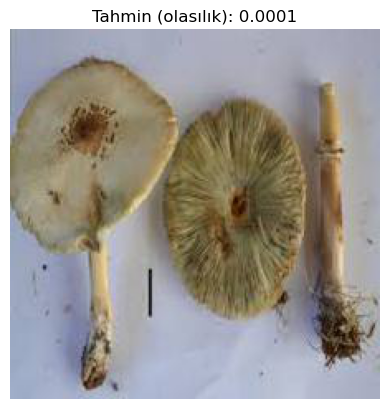

🔴 Model tahmini: Zehirli mantar


In [ ]:
import random
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# 1. Random görsel seç
image_dir = "mantar_veri_seti/test/zehirsiz"
random_image = random.choice(os.listdir(image_dir))
image_path = os.path.join(image_dir, random_image)

# 2. Görseli yükle ve ön işle
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0  # normalize
img_array = np.expand_dims(img_array, axis=0)  # batch dimension

# 3. TFLite modeli yükle
interpreter = tf.lite.Interpreter(model_path="mobilenet_model.tflite")
interpreter.allocate_tensors()

# Girdi/çıktı detayları
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 4. Tahmin yap
interpreter.set_tensor(input_details[0]['index'], img_array.astype(np.float32))
interpreter.invoke()
prediction = interpreter.get_tensor(output_details[0]['index'])[0][0]

# 5. Sonucu yazdır
plt.imshow(img)
plt.title(f"Tahmin (olasılık): {prediction:.4f}")
plt.axis('off')
plt.show()

#olasılık 0.5 in aşagısındaysa zehirli olarak veriyor ona dikkat et 

if prediction < 0.5:
    print("🔴 Model tahmini: Zehirli mantar")
else:
    print("🟢 Model tahmini: Zehirsiz mantar")
